In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import sys
sys.path.insert(0, '..')
import ml_utils
import pose_utils
from pose_utils import DEG_TO_RAD
from pose_utils import RAD_TO_SCALED
from pose_utils import MAX_DEPTH
from pose_utils import METERS_TO_SCALED
from pose_utils import INTENSITY_TO_SCALED

Step 1: choose your dataset

In [3]:
# tf_data_path = '/data/all_around_zones_3500_tf_data'  
# tf_data_path = '/data/all_around_scout_4501_tf_data'
# tf_data_path = '/data/face_to_face_zones_2500_tf_data'
tf_data_path = '/data/hopper_4500_tf_data'
# tf_data_path = '/data/t_formation_zones_3500_tf_data' 

# each dataset shows images of a different target object:
target = pose_utils.which_target(tf_data_path)
target

In [4]:
ds_split = 'train'
# ds_split = 'val'
# ds_split = 'test'

In [5]:
ds = ml_utils.load_dataset(tf_data_path + '_' + ds_split, compression='GZIP')

Step 2: take individual items from dataset

img shape: (480, 640, 4), found 4 channels
raw:   d = 0.334 , theta = -0.266    , yaw = 0.070 
human: d = 8.36 m, theta = -47.9 deg, yaw = 12.5 deg
img shape: (480, 640, 4), found 4 channels
raw:   d = 0.325 , theta = -0.682    , yaw = -0.007 
human: d = 8.13 m, theta = -122.8 deg, yaw = -1.2 deg
img shape: (480, 640, 4), found 4 channels
raw:   d = 0.396 , theta = -0.408    , yaw = 0.086 
human: d = 9.91 m, theta = -73.4 deg, yaw = 15.4 deg


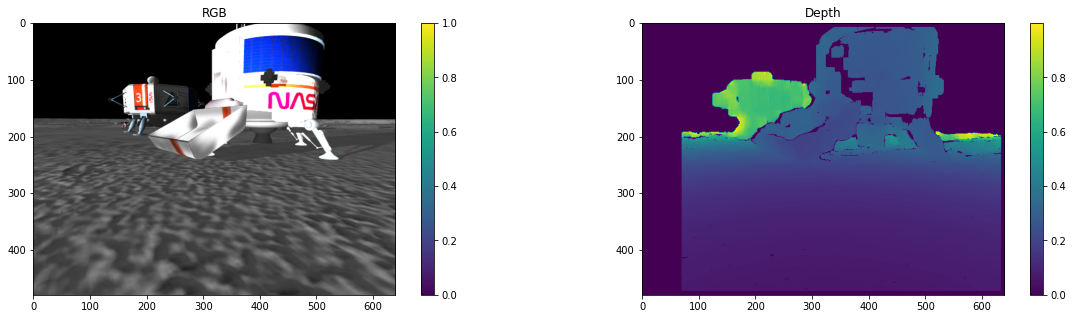

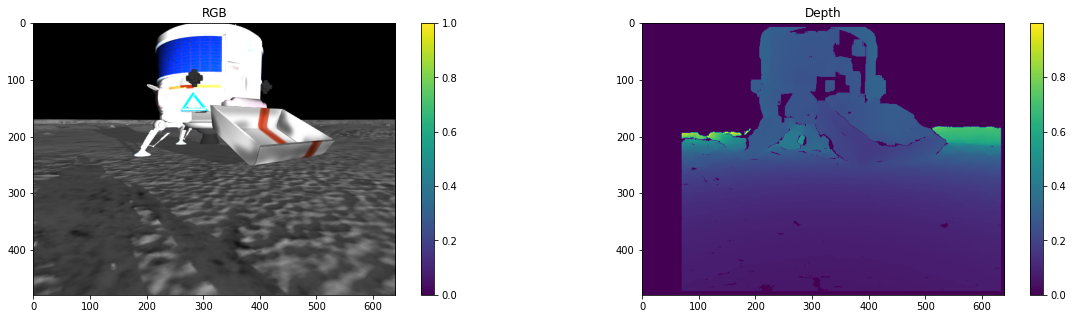

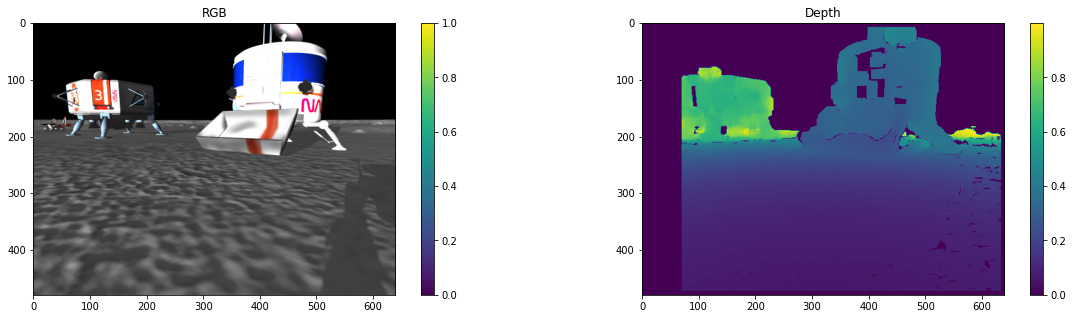

In [6]:
for image, label in ds.skip(6).take(3):
    pose_utils.show_rgbd(image, format='rgbd')
    d, theta, yaw = label.numpy()
    print(f"raw:   d = {d:.3f} , theta = {theta:.3f}    , yaw = {yaw:.3f} ")
    print(f"human: d = {d / METERS_TO_SCALED:.2f} m, theta = {theta / RAD_TO_SCALED / DEG_TO_RAD:.1f} deg, yaw = {yaw / RAD_TO_SCALED / DEG_TO_RAD:.1f} deg")


Step 3: visualize entire dataset 

In [7]:
# load entire dataset *labels* into memory (discard images)
labels = np.array([label.numpy() for _, label in ds])
labels.shape

(2911, 3)

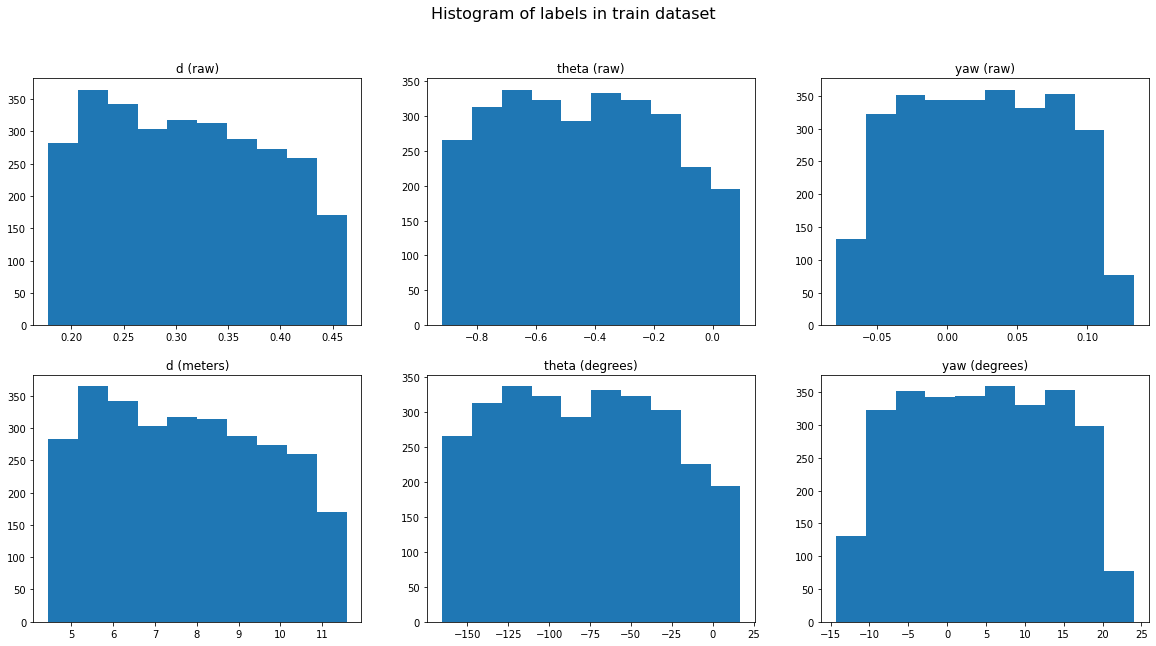

In [8]:
pose_utils.hist_labels(
    labels, 
    title=f'Histogram of labels in {ds_split} dataset'
);

-> uniform random distribution of each parameter, within bounds

In [9]:
pose_utils.subplot_labels(
    labels, 
    viz='raw', 
    title='plot of labels for entire dataset', 
    subset=None
)

In [10]:
pose_utils.subplot_labels(
    labels, 
    viz='human', 
    title='subset of labels scaled to human readable units', 
    subset=100
)

More intuitive: make a top view map of the poses in the dataset

Each blue dot is one sample : 
- position_x = distance * cos(theta)
- position_y = distance * sin(theta)

Each blue dot has a black arrow, indicating the pointing direction of the camera on the rover
absolute yaw = yaw + theta + pi/2

In [11]:
d_true = labels[:, 0] / METERS_TO_SCALED
theta_true = labels[:, 1] / RAD_TO_SCALED
yaw_true = labels[:, 2] / RAD_TO_SCALED

pose_utils.plot_optical_poses(
    d_true, theta_true, yaw_true, 
    title=f"top view of poses in {ds_split} dataset", 
    subset=None, 
    footprint=target
)

Notes:
1. the origin of all poses always coincides with the origin of the target object (e.g the processing plant, another rover)
1. there is sometimes a lack of poses near the edges of a dataset (e.g top right of the processing plant): this bias is due to uneven ground in this region that violated the criteria for the rover's pitch and roll to be within +/- 5 degrees to capture a dataset sample
1. the uniform distribution of `distance` and `theta` has the effect of creating:
- a more dense sampling of poses near the origin
- a more sparse sampling of poses far from the origin 

This *should* give higher accuracy for poses closer to the origin, which is a desirable trait.